In [6]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install --upgrade accelerate
!pip install --upgrade wandb


In [8]:
import logging
import os
import random
import sys
from dataclasses import dataclass, field
from typing import Optional
import pandas as pd
import datasets
import evaluate
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
import torch

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version


logger = logging.getLogger(__name__)

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)

In [9]:
import pandas as pd # Import the pandas library and assign it to the alias 'pd'
df = pd.read_csv("/content/drive/MyDrive/My_Research/Newspaper/Title_Classification/Dataset/NewspaperDataFinalVersion - Sports (1).csv")

In [10]:
df=df.drop(['Paper Name','Date'], axis=1)
df.head()

,Title,Category
0,দিনজুড়ে বোলিংয়ে হতাশা,Sports
1,আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা,Sports
2,নিজেদের ব্যাটিংয়ে চোখ সিমন্সের,Sports
3,ইস্টবেঙ্গলের কাছে বড় হার কিংসের,Sports
4,মূল আলোচ্য নাজমুলের অধিনায়কত্ব,Sports


In [11]:
df.columns=["Title","Category"]

In [12]:
training_args = TrainingArguments(
    learning_rate=2e-5,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    output_dir="./bertBaseMultilingualNew/",
    overwrite_output_dir=True,
    remove_unused_columns=False,
    local_rank= 1,
    load_best_model_at_end=True,
    save_total_limit=2,
    save_strategy="no"
)

max_train_samples = None
max_eval_samples=None
max_predict_samples=None
max_seq_length = 512
batch_size = 16

In [13]:
transformers.utils.logging.set_verbosity_info()

log_level = training_args.get_process_log_level()
logger.setLevel(log_level)
datasets.utils.logging.set_verbosity(log_level)
transformers.utils.logging.set_verbosity(log_level)
transformers.utils.logging.enable_default_handler()
transformers.utils.logging.enable_explicit_format()
logger.warning(
    f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}"
    + f" distributed training: {bool(training_args.local_rank != -1)}, 16-bits training: {training_args.fp16}"
)
logger.info(f"Training/evaluation parameters {training_args}")

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=Non

In [14]:
model_name = 'bert-base-multilingual-cased'

In [15]:
set_seed(training_args.seed)

In [16]:
punctuations = ["|","‘",">","<","*",   "।", ",", ";", ":", "?", "!", "'", ".", "\"", "-",
                "[", "]", "{", "}", "(", ")", '–', "—", "―", "~"]

def remove_url(word):
  return word.split("http")[0].strip()

def extreme_process(word):
  word_list = [word]
  splitter_list = ["**","*", "…", "-"]

  for i in splitter_list:
    if i in word:
      temp_list = word.split(i)
      word_list = list(filter(lambda x:x.strip() != "", temp_list))
      return word_list
  return word_list


def process_word(word):
  word = word.strip()
  if len(word) == 0:
    return []
  elif len(word) == 1:
    if word not in punctuations:
      return [word]
    else:
      return []
  else:
    word = remove_url(word)

    if len(word) == 0:
      return []
    elif len(word) == 1:
      if word in punctuations:
        return []
      else:
        return [word]
    else:
      if word[0] in punctuations:
        word = word[1:]
      if word[-1] in punctuations:
        word = word[:-1]

      word = extreme_process(word)

      return word


In [17]:
import pandas as pd
l2id = {'Sports': 2, 'National': 1, 'International': 0}
newdf = df
print(newdf.head())

                                 Title Category
0                দিনজুড়ে বোলিংয়ে হতাশা   Sports
1  আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা   Sports
2       নিজেদের ব্যাটিংয়ে চোখ সিমন্সের   Sports
3      ইস্টবেঙ্গলের কাছে বড় হার কিংসের   Sports
4       মূল আলোচ্য নাজমুলের অধিনায়কত্ব   Sports


In [18]:
for index, row in newdf.iterrows():
  unprocessed_spliited_word = row["Title"].split(" ")
  processed_word_list = []
  for i in unprocessed_spliited_word:
    processed_word_list += process_word(i)
  newdf.at[index, "Title"] = " ".join(processed_word_list)

In [19]:
newdf['Category'] = newdf['Category'].map(l2id)
print(newdf.head())

                                 Title  Category
0                দিনজুড়ে বোলিংয়ে হতাশা         2
1  আবারও ছাদখোলা বাসে উৎসবের প্রতিজ্ঞা         2
2       নিজেদের ব্যাটিংয়ে চোখ সিমন্সের         2
3      ইস্টবেঙ্গলের কাছে বড় হার কিংসের         2
4       মূল আলোচ্য নাজমুলের অধিনায়কত্ব         2


In [20]:
newdf = Dataset.from_pandas(newdf)
print(newdf)

Dataset({
    features: ['Title', 'Category'],
    num_rows: 6150
})


In [21]:
raw_datasets = DatasetDict(
    {"train": newdf,}
)

In [22]:
label_list = raw_datasets["train"].unique("Category")
print(label_list)

[2, 0, 1]


In [23]:
label_list.sort()  # sort the labels for determine
print(label_list)

[0, 1, 2]


In [24]:
num_labels = len(label_list)
print(num_labels)

3


In [25]:
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task=None,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

[INFO|configuration_utils.py:679] 2024-11-29 14:10:26,167 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/config.json
[INFO|configuration_utils.py:746] 2024-11-29 14:10:26,177 >> Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,

In [26]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=None,
    use_fast=True,
    revision="main",
    use_auth_token=None,
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

[INFO|configuration_utils.py:679] 2024-11-29 14:10:26,729 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/config.json
[INFO|configuration_utils.py:746] 2024-11-29 14:10:26,734 >> Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_emb

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

[INFO|tokenization_utils_base.py:2211] 2024-11-29 14:10:29,867 >> loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/vocab.txt
[INFO|tokenization_utils_base.py:2211] 2024-11-29 14:10:29,875 >> loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/tokenizer.json
[INFO|tokenization_utils_base.py:2211] 2024-11-29 14:10:29,879 >> loading file added_tokens.json from cache at None
[INFO|tokenization_utils_base.py:2211] 2024-11-29 14:10:29,883 >> loading file special_tokens_map.json from cache at None
[INFO|tokenization_utils_base.py:2211] 2024-11-29 14:10:29,886 >> loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/tokenizer_config.json
[INFO|configuration_utils.py:679] 2024

In [27]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    from_tf=bool(".ckpt" in model_name),
    config=config,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
    ignore_mismatched_sizes=False,
)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

[INFO|modeling_utils.py:3937] 2024-11-29 14:10:40,224 >> loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/3f076fdb1ab68d5b2880cb87a0886f315b8146f8/model.safetensors
[INFO|logging.py:343] 2024-11-29 14:10:40,438 >> A pretrained model of type `BertForSequenceClassification` contains parameters that have been renamed internally (a few are listed below but more are present in the model):
* `bert.embeddings.LayerNorm.gamma` -> `bert.embeddings.LayerNorm.weight`
* `bert.encoder.layer.0.attention.output.LayerNorm.gamma` -> `{'bert.embeddings.LayerNorm.gamma': 'bert.embeddings.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.gamma': {...}, 'bert.encoder.layer.0.output.LayerNorm.gamma': {...}, 'bert.encoder.layer.1.attention.output.LayerNorm.gamma': {...}, 'bert.encoder.layer.1.output.LayerNorm.gamma': {...}, 'bert.encoder.layer.10.attention.output.LayerNorm.gamma': {...}, 'bert.encoder.layer.10.o

In [28]:
non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "Category"]
print(non_label_column_names)

['Title']


In [29]:
sentence_key= non_label_column_names[0]
print(sentence_key)

Title


In [30]:
padding = "max_length"
label_to_id = None

if (model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id):
    # Some have all caps in their config, some don't.
    label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
    if sorted(label_name_to_id.keys()) == sorted(label_list):
        label_to_id = {i: int(label_name_to_id[label_list[i]]) for i in range(num_labels)}
    else:
        logger.warning(
            "Your model seems to have been trained with labels, but they don't match the dataset: ",
            f"model labels: {sorted(label_name_to_id.keys())}, dataset labels: {sorted(label_list)}."
            "\nIgnoring the model labels as a result.",)

In [31]:
if label_to_id is not None:
    model.config.label2id = label_to_id
    model.config.id2label = {id: label for label, id in config.label2id.items()}

In [32]:
if 128 > tokenizer.model_max_length:
    logger.warning(
        f"The max_seq_length passed ({128}) is larger than the maximum length for the"
        f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}.")

In [33]:
max_seq_length = min(128, tokenizer.model_max_length)
print(max_seq_length)

128


In [34]:
def preprocess_function(examples):
    # Tokenize the texts
    args = (
        (examples[sentence_key],))
    result = tokenizer(*args, padding=padding, max_length=max_seq_length, truncation=True)

    # Map labels to IDs (not necessary for GLUE tasks)
    if label_to_id is not None and "label" in examples:
        result["label"] = [(label_to_id[l] if l != -1 else -1) for l in examples["label"]]
    return result

In [35]:
raw_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    load_from_cache_file=True,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/6150 [00:00<?, ? examples/s]

In [36]:
if "train" not in raw_datasets:
    raise ValueError("requires a train dataset")

In [37]:
train_dataset = raw_datasets["train"]
print(train_dataset)

Dataset({
    features: ['Title', 'Category', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6150
})


In [38]:
print(max_predict_samples)

None


In [39]:
if max_predict_samples is not None:
    max_predict_samples_n = min(len(predict_dataset), max_predict_samples)
    predict_dataset = predict_dataset.select(range(max_predict_samples_n))

In [40]:
for index in random.sample(range(len(train_dataset)), 3):
    logger.info(f"Sample {index} of the training set: {train_dataset[index]}.")

INFO:__main__:Sample 5238 of the training set: {'Title': 'থুনবার্গকে জরিমানা করলেন আদালত', 'Category': 0, 'input_ids': [101, 964, 64437, 36213, 88213, 18243, 955, 82742, 29454, 12079, 948, 11128, 28799, 11737, 938, 106352, 13458, 13542, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1

In [41]:
metric = evaluate.load("accuracy")

In [42]:
def calculate_micro_f1_score(true_positives, false_positives, false_negatives):
    total_tp = sum(true_positives)
    total_fp = sum(false_positives)
    total_fn = sum(false_negatives)

    micro_precision = total_tp / (total_tp + total_fp + 1e-9)
    micro_recall = total_tp / (total_tp + total_fn + 1e-9)

    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall + 1e-9)

    return micro_f1

In [43]:
def compute_metrics(p):
    """
    Calculates and returns a dictionary of metrics (accuracy, precision, recall, f1)
    for a given prediction set.

    Args:
        p: EvalPrediction object containing predictions and label_ids.

    Returns:
        Dictionary of metrics.
    """

    # Get predictions and labels
    preds = np.argmax(p.predictions, axis=1)  # Assuming predictions are logits
    labels = p.label_ids

    # Convert labels to float32
    labels = labels.astype(np.float32)

    # Assuming your model outputs logits and you have a fixed number of labels
    num_labels = len(np.unique(labels))  # Infer the number of labels from the data
    # or
    # num_labels = 5 # Assign num_labels to number of classes in your dataset if known before runtime.

    # Initialize dictionaries to store TP, FP, and FN for each class
    true_positives = {label: 0 for label in range(num_labels)}
    false_positives = {label: 0 for label in range(num_labels)}
    false_negatives = {label: 0 for label in range(num_labels)}

    # Calculate TP, FP, and FN for each class
    for prediction, true_label in zip(preds, labels):
        if prediction == true_label:
            true_positives[true_label] += 1
        else:
            false_positives[prediction] += 1
            false_negatives[true_label] += 1

    # Calculate overall accuracy
    accuracy = np.sum(preds == labels) / len(labels)

    # Calculate precision, recall, and F1 score for each class
    precision = {}
    recall = {}
    f1 = {}

    for label in range(num_labels):
        # Avoid division by zero if there are no predictions or true labels for a class
        if true_positives[label] + false_positives[label] == 0:
            precision[label] = 0.0
        else:
            precision[label] = true_positives[label] / (true_positives[label] + false_positives[label])

        if true_positives[label] + false_negatives[label] == 0:
            recall[label] = 0.0
        else:
            recall[label] = true_positives[label] / (true_positives[label] + false_negatives[label])

        if precision[label] + recall[label] == 0:
            f1[label] = 0.0
        else:
            f1[label] = 2 * (precision[label] * recall[label]) / (precision[label] + recall[label])

    # Calculate macro-averaged precision, recall, and F1 score
    macro_precision = np.mean(list(precision.values()))
    macro_recall = np.mean(list(recall.values()))
    macro_f1 = np.mean(list(f1.values()))

    # Return the metrics
    return {
        "accuracy": accuracy,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
    }

In [44]:
data_collator = default_data_collator

In [45]:
from sklearn.model_selection import train_test_split
import numpy as np
from datasets import Dataset

# Convert the Hugging Face Dataset to a NumPy array or list
# Assuming your dataset has a column named 'Title' and 'Category'
train_Titles = train_dataset["Title"]
train_Categorys = train_dataset["Category"]

# Now you can use train_test_split
train_Titles, eval_Titles, train_Categorys, eval_Categorys = train_test_split(
    train_Titles, train_Categorys, test_size=0.2, random_state=42
)

# Create new Hugging Face Datasets from the split data, renaming 'Category' to 'labels'
train_dataset = Dataset.from_dict({"Title": train_Titles, "labels": train_Categorys})
eval_dataset = Dataset.from_dict({"Title": eval_Titles, "labels": eval_Categorys})


def preprocess_function(examples):
    # Tokenize the texts
    return tokenizer(examples["Title"], padding="max_length", truncation=True)

# Apply the preprocessing function to your datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
eval_dataset = eval_dataset.map(preprocess_function, batched=True)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,  # Pass the training dataset to the trainer
    eval_dataset=eval_dataset,  # Pass the validation dataset to the trainer
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

Map:   0%|          | 0/4920 [00:00<?, ? examples/s]

Map:   0%|          | 0/1230 [00:00<?, ? examples/s]

<ipython-input-45-571c33f6d8ae>:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [46]:
import os
#os.environ["WANDB_START_TIMEOUT"] = "300"  # Example: 300 seconds
os.environ["WANDB_DISABLED"] = "true"

In [47]:
train_result = trainer.train()

[INFO|trainer.py:2314] 2024-11-29 14:10:54,711 >> ***** Running training *****
[INFO|trainer.py:2315] 2024-11-29 14:10:54,715 >>   Num examples = 4,920
[INFO|trainer.py:2316] 2024-11-29 14:10:54,725 >>   Num Epochs = 5
[INFO|trainer.py:2317] 2024-11-29 14:10:54,736 >>   Instantaneous batch size per device = 16
[INFO|trainer.py:2320] 2024-11-29 14:10:54,741 >>   Total train batch size (w. parallel, distributed & accumulation) = 16
[INFO|trainer.py:2321] 2024-11-29 14:10:54,743 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:2322] 2024-11-29 14:10:54,756 >>   Total optimization steps = 1,540
[INFO|trainer.py:2323] 2024-11-29 14:10:54,759 >>   Number of trainable parameters = 177,855,747
[INFO|integration_utils.py:812] 2024-11-29 14:10:54,788 >> Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a d

Step,Training Loss
500,0.554400
1000,0.275600
1500,0.150800


[INFO|trainer.py:2591] 2024-11-29 14:50:26,054 >> 

Training completed. Do not forget to share your model on huggingface.co/models =)




In [48]:
metrics = train_result.metrics
max_train_samples = (
    max_train_samples if max_train_samples is not None else len(train_dataset)
)
metrics["train_samples"] = min(max_train_samples, len(train_dataset))

In [49]:
trainer.save_model()
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

[INFO|trainer.py:3812] 2024-11-29 14:50:26,125 >> Saving model checkpoint to ./bertBaseMultilingualNew/
[INFO|configuration_utils.py:414] 2024-11-29 14:50:26,131 >> Configuration saved in ./bertBaseMultilingualNew/config.json
[INFO|modeling_utils.py:3035] 2024-11-29 14:50:29,190 >> Model weights saved in ./bertBaseMultilingualNew/model.safetensors
[INFO|tokenization_utils_base.py:2646] 2024-11-29 14:50:29,198 >> tokenizer config file saved in ./bertBaseMultilingualNew/tokenizer_config.json
[INFO|tokenization_utils_base.py:2655] 2024-11-29 14:50:29,200 >> Special tokens file saved in ./bertBaseMultilingualNew/special_tokens_map.json


***** train metrics *****
  epoch                    =        5.0
  total_flos               =  6028069GF
  train_loss               =      0.322
  train_runtime            = 0:39:31.33
  train_samples            =       4920
  train_samples_per_second =     10.374
  train_steps_per_second   =      0.649


In [50]:
logger.info("*** Evaluate ***")

metrics = trainer.evaluate(eval_dataset=eval_dataset)

max_eval_samples = (
    max_eval_samples if max_eval_samples is not None else len(eval_dataset)
)
metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

INFO:__main__:*** Evaluate ***
[INFO|trainer.py:4128] 2024-11-29 14:50:29,307 >> 
***** Running Evaluation *****
[INFO|trainer.py:4130] 2024-11-29 14:50:29,310 >>   Num examples = 1230
[INFO|trainer.py:4133] 2024-11-29 14:50:29,313 >>   Batch size = 16


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.8764
  eval_loss               =     0.5276
  eval_macro_f1           =     0.8771
  eval_macro_precision    =     0.8779
  eval_macro_recall       =     0.8768
  eval_runtime            = 0:00:39.79
  eval_samples            =       1230
  eval_samples_per_second =     30.906
  eval_steps_per_second   =      1.935


In [51]:
# Assuming 'trainer' and 'eval_dataset' are defined as in your code
predictions = trainer.predict(eval_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

[INFO|trainer.py:4128] 2024-11-29 14:56:01,499 >> 
***** Running Prediction *****
[INFO|trainer.py:4130] 2024-11-29 14:56:01,502 >>   Num examples = 1230
[INFO|trainer.py:4133] 2024-11-29 14:56:01,504 >>   Batch size = 16


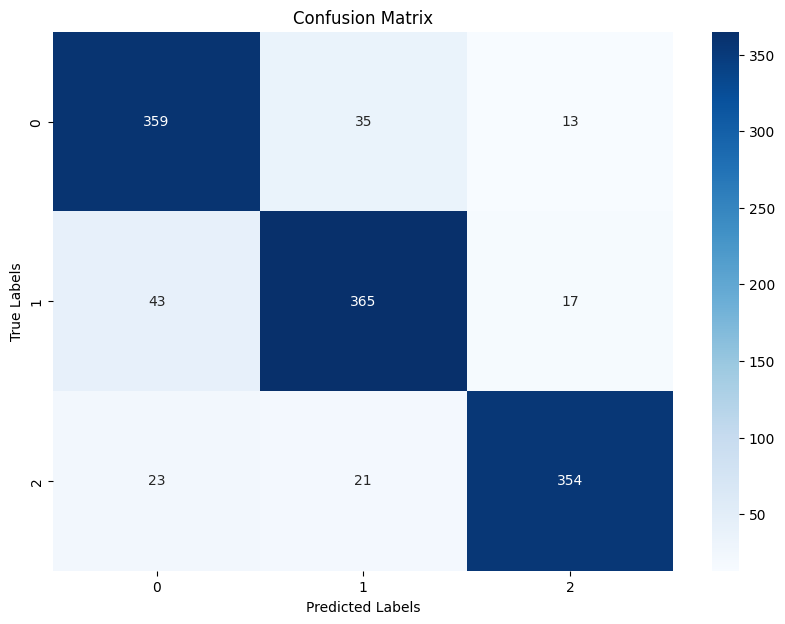

In [52]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels from the evaluation dataset
true_labels = predictions.label_ids

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()